# **Comparison of link prediction with random walks based node embedding**

This demo notebook compares the link prediction performance of the embeddings learned by Node2Vec [1], Attri2Vec [2], GraphSAGE [3] and GCN [4] on the Cora dataset. The notebook is taken from the demos of the stellargraph platform.


https://stellargraph.readthedocs.io/en/stable/demos/link-prediction/homogeneous-comparison-link-prediction.html
https://github.com/stellargraph/stellargraph/blob/9370caed1137c2527523a39212072df1760ca00f/demos/link-prediction/homogeneous-comparison-link-prediction.ipynb


**References:**
* [1] Node2Vec: Scalable Feature Learning for Networks. A. Grover, J. Leskovec. 
ACM SIGKDD International Conference on Knowledge Discovery and Data Mining (KDD), 2016.
* [2] Attributed Network Embedding via Subspace Discovery. D. Zhang, Y. Jie, X. Zhu and C. Zhang. Data Mining and Knowledge Discovery, 2019.
* [3] Inductive Representation Learning on Large Graphs. W.L. Hamilton, R. Ying, and J. Leskovec. Neural Information Processing Systems (NIPS), 2017.
* [4] Graph Convolutional Networks (GCN): Semi-Supervised Classification with Graph Convolutional Networks. Thomas N. Kipf, Max Welling. International Conference on Learning Representations (ICLR), 2017

In [1]:
import matplotlib.pyplot as plt
from math import isclose
from sklearn.decomposition import PCA
import os
import networkx as nx
import numpy as np
import pandas as pd
from stellargraph import StellarGraph, datasets
from stellargraph.data import EdgeSplitter
from collections import Counter
import multiprocessing
from IPython.display import display, HTML
from sklearn.model_selection import train_test_split

%matplotlib inline

In [2]:
dataset = datasets.Cora()
display(HTML(dataset.description))
graph, _ = dataset.load(largest_connected_component_only=True, str_node_ids=True)

print(graph.info())

StellarGraph: Undirected multigraph
 Nodes: 2485, Edges: 5209

 Node types:
  paper: [2485]
    Features: float32 vector, length 1433
    Edge types: paper-cites->paper

 Edge types:
    paper-cites->paper: [5209]
        Weights: all 1 (default)
        Features: none


In [3]:
# Define an edge splitter on the original graph:
edge_splitter_test = EdgeSplitter(graph)

# Randomly sample a fraction p=0.1 of all positive links, and same number of negative links, from graph, and obtain the
# reduced graph graph_test with the sampled links removed:
graph_test, examples_test, labels_test = edge_splitter_test.train_test_split(
    p=0.1, method="global"
)

print(graph_test.info())

** Sampled 520 positive and 520 negative edges. **
StellarGraph: Undirected multigraph
 Nodes: 2485, Edges: 4689

 Node types:
  paper: [2485]
    Features: float32 vector, length 1433
    Edge types: paper-cites->paper

 Edge types:
    paper-cites->paper: [4689]
        Weights: all 1 (default)
        Features: none


In [4]:
# Do the same process to compute a training subset from within the test graph
edge_splitter_train = EdgeSplitter(graph_test)
graph_train, examples, labels = edge_splitter_train.train_test_split(
    p=0.1, method="global"
)
(
    examples_train,
    examples_model_selection,
    labels_train,
    labels_model_selection,
) = train_test_split(examples, labels, train_size=0.75, test_size=0.25)

print(graph_train.info())



** Sampled 468 positive and 468 negative edges. **
StellarGraph: Undirected multigraph
 Nodes: 2485, Edges: 4221

 Node types:
  paper: [2485]
    Features: float32 vector, length 1433
    Edge types: paper-cites->paper

 Edge types:
    paper-cites->paper: [4221]
        Weights: all 1 (default)
        Features: none


In [5]:
from stellargraph.data import BiasedRandomWalk


def create_biased_random_walker(graph, walk_num, walk_length):
    # parameter settings for "p" and "q":
    p = 1.0
    q = 1.0
    return BiasedRandomWalk(graph, n=walk_num, length=walk_length, p=p, q=q)



In [6]:
walk_length = 5
epochs = 6
batch_size = 50

In [7]:
from stellargraph.data import UnsupervisedSampler
from stellargraph.mapper import Node2VecLinkGenerator, Node2VecNodeGenerator
from stellargraph.layer import Node2Vec, link_classification
from tensorflow import keras


def node2vec_embedding(graph, name):

    # Set the embedding dimension and walk number:
    dimension = 128
    walk_number = 20

    print(f"Training Node2Vec for '{name}':")

    graph_node_list = list(graph.nodes())

    # Create the biased random walker to generate random walks
    walker = create_biased_random_walker(graph, walk_number, walk_length)

    # Create the unsupervised sampler to sample (target, context) pairs from random walks
    unsupervised_samples = UnsupervisedSampler(
        graph, nodes=graph_node_list, walker=walker
    )

    # Define a Node2Vec training generator, which generates batches of training pairs
    generator = Node2VecLinkGenerator(graph, batch_size)

    # Create the Node2Vec model
    node2vec = Node2Vec(dimension, generator=generator)

    # Build the model and expose input and output sockets of Node2Vec, for node pair inputs
    x_inp, x_out = node2vec.in_out_tensors()

    # Use the link_classification function to generate the output of the Node2Vec model
    prediction = link_classification(
        output_dim=1, output_act="sigmoid", edge_embedding_method="dot"
    )(x_out)

    # Stack the Node2Vec encoder and prediction layer into a Keras model, and specify the loss
    model = keras.Model(inputs=x_inp, outputs=prediction)
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-3),
        loss=keras.losses.binary_crossentropy,
        metrics=[keras.metrics.binary_accuracy],
    )

    # Train the model
    model.fit(
        generator.flow(unsupervised_samples),
        epochs=epochs,
        verbose=2,
        use_multiprocessing=False,
        workers=4,
        shuffle=True,
    )

    # Build the model to predict node representations from node ids with the learned Node2Vec model parameters
    x_inp_src = x_inp[0]
    x_out_src = x_out[0]
    embedding_model = keras.Model(inputs=x_inp_src, outputs=x_out_src)

    # Get representations for all nodes in ``graph``
    node_gen = Node2VecNodeGenerator(graph, batch_size).flow(graph_node_list)
    node_embeddings = embedding_model.predict(node_gen, workers=1, verbose=0)

    def get_embedding(u):
        u_index = graph_node_list.index(u)
        return node_embeddings[u_index]

    return get_embedding

In [8]:
from stellargraph.mapper import Attri2VecLinkGenerator, Attri2VecNodeGenerator
from stellargraph.layer import Attri2Vec


def attri2vec_embedding(graph, name):

    # Set the embedding dimension and walk number:
    dimension = [128]
    walk_number = 4

    print(f"Training Attri2Vec for '{name}':")

    graph_node_list = list(graph.nodes())

    # Create the biased random walker to generate random walks
    walker = create_biased_random_walker(graph, walk_number, walk_length)

    # Create the unsupervised sampler to sample (target, context) pairs from random walks
    unsupervised_samples = UnsupervisedSampler(
        graph, nodes=graph_node_list, walker=walker
    )

    # Define an Attri2Vec training generator, which generates batches of training pairs
    generator = Attri2VecLinkGenerator(graph, batch_size)

    # Create the Attri2Vec model
    attri2vec = Attri2Vec(
        layer_sizes=dimension, generator=generator, bias=False, normalize=None
    )

    # Build the model and expose input and output sockets of Attri2Vec, for node pair inputs
    x_inp, x_out = attri2vec.in_out_tensors()

    # Use the link_classification function to generate the output of the Attri2Vec model
    prediction = link_classification(
        output_dim=1, output_act="sigmoid", edge_embedding_method="ip"
    )(x_out)

    # Stack the Attri2Vec encoder and prediction layer into a Keras model, and specify the loss
    model = keras.Model(inputs=x_inp, outputs=prediction)
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-3),
        loss=keras.losses.binary_crossentropy,
        metrics=[keras.metrics.binary_accuracy],
    )

    # Train the model
    model.fit(
        generator.flow(unsupervised_samples),
        epochs=epochs,
        verbose=2,
        use_multiprocessing=False,
        workers=1,
        shuffle=True,
    )

    # Build the model to predict node representations from node features with the learned Attri2Vec model parameters
    x_inp_src = x_inp[0]
    x_out_src = x_out[0]
    embedding_model = keras.Model(inputs=x_inp_src, outputs=x_out_src)

    # Get representations for all nodes in ``graph``
    node_gen = Attri2VecNodeGenerator(graph, batch_size).flow(graph_node_list)
    node_embeddings = embedding_model.predict(node_gen, workers=1, verbose=0)

    def get_embedding(u):
        u_index = graph_node_list.index(u)
        return node_embeddings[u_index]

    return get_embedding

In [9]:
from stellargraph.mapper import GraphSAGELinkGenerator, GraphSAGENodeGenerator
from stellargraph.layer import GraphSAGE


def graphsage_embedding(graph, name):

    # Set the embedding dimensions, the numbers of sampled neighboring nodes and walk number:
    dimensions = [128, 128]
    num_samples = [10, 5]
    walk_number = 1

    print(f"Training GraphSAGE for '{name}':")

    graph_node_list = list(graph.nodes())

    # Create the biased random walker to generate random walks
    walker = create_biased_random_walker(graph, walk_number, walk_length)

    # Create the unsupervised sampler to sample (target, context) pairs from random walks
    unsupervised_samples = UnsupervisedSampler(
        graph, nodes=graph_node_list, walker=walker
    )

    # Define a GraphSAGE training generator, which generates batches of training pairs
    generator = GraphSAGELinkGenerator(graph, batch_size, num_samples)

    # Create the GraphSAGE model
    graphsage = GraphSAGE(
        layer_sizes=dimensions,
        generator=generator,
        bias=True,
        dropout=0.0,
        normalize="l2",
    )

    # Build the model and expose input and output sockets of GraphSAGE, for node pair inputs
    x_inp, x_out = graphsage.in_out_tensors()

    # Use the link_classification function to generate the output of the GraphSAGE model
    prediction = link_classification(
        output_dim=1, output_act="sigmoid", edge_embedding_method="ip"
    )(x_out)

    # Stack the GraphSAGE encoder and prediction layer into a Keras model, and specify the loss
    model = keras.Model(inputs=x_inp, outputs=prediction)
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-3),
        loss=keras.losses.binary_crossentropy,
        metrics=[keras.metrics.binary_accuracy],
    )

    # Train the model
    model.fit(
        generator.flow(unsupervised_samples),
        epochs=epochs,
        verbose=2,
        use_multiprocessing=False,
        workers=4,
        shuffle=True,
    )

    # Build the model to predict node representations from node features with the learned GraphSAGE model parameters
    x_inp_src = x_inp[0::2]
    x_out_src = x_out[0]
    embedding_model = keras.Model(inputs=x_inp_src, outputs=x_out_src)

    # Get representations for all nodes in ``graph``
    node_gen = GraphSAGENodeGenerator(graph, batch_size, num_samples).flow(
        graph_node_list
    )
    node_embeddings = embedding_model.predict(node_gen, workers=1, verbose=0)

    def get_embedding(u):
        u_index = graph_node_list.index(u)
        return node_embeddings[u_index]

    return get_embedding

In [10]:
from stellargraph.mapper import FullBatchLinkGenerator, FullBatchNodeGenerator
from stellargraph.layer import GCN, LinkEmbedding


def gcn_embedding(graph, name):

    # Set the embedding dimensions and walk number:
    dimensions = [128, 128]
    walk_number = 1

    print(f"Training GCN for '{name}':")

    graph_node_list = list(graph.nodes())

    # Create the biased random walker to generate random walks
    walker = create_biased_random_walker(graph, walk_number, walk_length)

    # Create the unsupervised sampler to sample (target, context) pairs from random walks
    unsupervised_samples = UnsupervisedSampler(
        graph, nodes=graph_node_list, walker=walker
    )

    # Define a GCN training generator, which generates the full batch of training pairs
    generator = FullBatchLinkGenerator(graph, method="gcn")

    # Create the GCN model
    gcn = GCN(
        layer_sizes=dimensions,
        activations=["relu", "relu"],
        generator=generator,
        dropout=0.3,
    )

    # Build the model and expose input and output sockets of GCN, for node pair inputs
    x_inp, x_out = gcn.in_out_tensors()

    # Use the dot product of node embeddings to make node pairs co-occurring in short random walks represented closely
    prediction = LinkEmbedding(activation="sigmoid", method="ip")(x_out)
    prediction = keras.layers.Reshape((-1,))(prediction)

    # Stack the GCN encoder and prediction layer into a Keras model, and specify the loss
    model = keras.Model(inputs=x_inp, outputs=prediction)
    model.compile(
        optimizer=keras.optimizers.Adam(lr=1e-3),
        loss=keras.losses.binary_crossentropy,
        metrics=[keras.metrics.binary_accuracy],
    )

    # Train the model
    batches = unsupervised_samples.run(batch_size)
    for epoch in range(epochs):
        print(f"Epoch: {epoch+1}/{epochs}")
        batch_iter = 1
        for batch in batches:
            samples = generator.flow(batch[0], targets=batch[1], use_ilocs=True)[0]
            [loss, accuracy] = model.train_on_batch(x=samples[0], y=samples[1])
            output = (
                f"{batch_iter}/{len(batches)} - loss:"
                + " {:6.4f}".format(loss)
                + " - binary_accuracy:"
                + " {:6.4f}".format(accuracy)
            )
            if batch_iter == len(batches):
                print(output)
            else:
                print(output, end="\r")
            batch_iter = batch_iter + 1

    # Get representations for all nodes in ``graph``
    embedding_model = keras.Model(inputs=x_inp, outputs=x_out)
    node_embeddings = embedding_model.predict(
        generator.flow(list(zip(graph_node_list, graph_node_list)))
    )
    node_embeddings = node_embeddings[0][:, 0, :]

    def get_embedding(u):
        u_index = graph_node_list.index(u)
        return node_embeddings[u_index]

    return get_embedding

In [11]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler


# 1. link embeddings
def link_examples_to_features(link_examples, transform_node, binary_operator):
    return [
        binary_operator(transform_node(src), transform_node(dst))
        for src, dst in link_examples
    ]


# 2. training classifier
def train_link_prediction_model(
    link_examples, link_labels, get_embedding, binary_operator
):
    clf = link_prediction_classifier()
    link_features = link_examples_to_features(
        link_examples, get_embedding, binary_operator
    )
    clf.fit(link_features, link_labels)
    return clf


def link_prediction_classifier(max_iter=5000):
    lr_clf = LogisticRegressionCV(Cs=10, cv=10, scoring="roc_auc", max_iter=max_iter)
    return Pipeline(steps=[("sc", StandardScaler()), ("clf", lr_clf)])


# 3. and 4. evaluate classifier
def evaluate_link_prediction_model(
    clf, link_examples_test, link_labels_test, get_embedding, binary_operator
):
    link_features_test = link_examples_to_features(
        link_examples_test, get_embedding, binary_operator
    )
    score = evaluate_roc_auc(clf, link_features_test, link_labels_test)
    return score


def evaluate_roc_auc(clf, link_features, link_labels):
    predicted = clf.predict_proba(link_features)

    # check which class corresponds to positive links
    positive_column = list(clf.classes_).index(1)
    return roc_auc_score(link_labels, predicted[:, positive_column])


In [12]:
def operator_hadamard(u, v):
    return u * v


def operator_l1(u, v):
    return np.abs(u - v)


def operator_l2(u, v):
    return (u - v) ** 2


def operator_avg(u, v):
    return (u + v) / 2.0


def run_link_prediction(binary_operator, embedding_train):
    clf = train_link_prediction_model(
        examples_train, labels_train, embedding_train, binary_operator
    )
    score = evaluate_link_prediction_model(
        clf,
        examples_model_selection,
        labels_model_selection,
        embedding_train,
        binary_operator,
    )

    return {
        "classifier": clf,
        "binary_operator": binary_operator,
        "score": score,
    }


binary_operators = [operator_hadamard, operator_l1, operator_l2, operator_avg]

In [13]:
def train_and_evaluate(embedding, name):

    embedding_train = embedding(graph_train, "Train Graph")

    # Train the link classification model with the learned embedding
    results = [run_link_prediction(op, embedding_train) for op in binary_operators]
    best_result = max(results, key=lambda result: result["score"])
    print(
        f"\nBest result with '{name}' embeddings from '{best_result['binary_operator'].__name__}'"
    )
    display(
        pd.DataFrame(
            [(result["binary_operator"].__name__, result["score"]) for result in results],
            columns=("name", "ROC AUC"),
        ).set_index("name")
    )

    # Evaluate the best model using the test set
    test_score = evaluate_link_prediction_model(
        best_result["classifier"],
        examples_test,
        labels_test,
        embedding_train,
        best_result["binary_operator"],
    )

    # Calculate edge features for test data
    link_features = link_examples_to_features(
        examples_test, embedding_train, best_result["binary_operator"] 
    )

    # Learn a projection from 128 dimensions to 2
    pca = PCA(n_components=2)
    X_transformed = pca.fit_transform(link_features)

    # plot the 2-dimensional points
    plt.figure(figsize=(16, 12))
    plt.scatter(
      X_transformed[:, 0],
      X_transformed[:, 1],
      c=np.where(labels_test == 1, "b", "r"),
      alpha=0.5,
    )

    return test_score



Training Node2Vec for 'Train Graph':
link_classification: using 'dot' method to combine node embeddings into edge embeddings
Epoch 1/6
7674/7674 - 92s - loss: 0.5554 - binary_accuracy: 0.6727 - 92s/epoch - 12ms/step
Epoch 2/6
7674/7674 - 92s - loss: 0.4488 - binary_accuracy: 0.7521 - 92s/epoch - 12ms/step
Epoch 3/6
7674/7674 - 90s - loss: 0.2890 - binary_accuracy: 0.8803 - 90s/epoch - 12ms/step
Epoch 4/6
7674/7674 - 89s - loss: 0.1715 - binary_accuracy: 0.9407 - 89s/epoch - 12ms/step
Epoch 5/6
7674/7674 - 89s - loss: 0.1373 - binary_accuracy: 0.9514 - 89s/epoch - 12ms/step
Epoch 6/6
7674/7674 - 90s - loss: 0.1282 - binary_accuracy: 0.9547 - 90s/epoch - 12ms/step

Best result with 'Node2Vec' embeddings from 'operator_l2'


,ROC AUC
name,
operator_hadamard,0.791487
operator_l1,0.825203
operator_l2,0.835662
operator_avg,0.545162


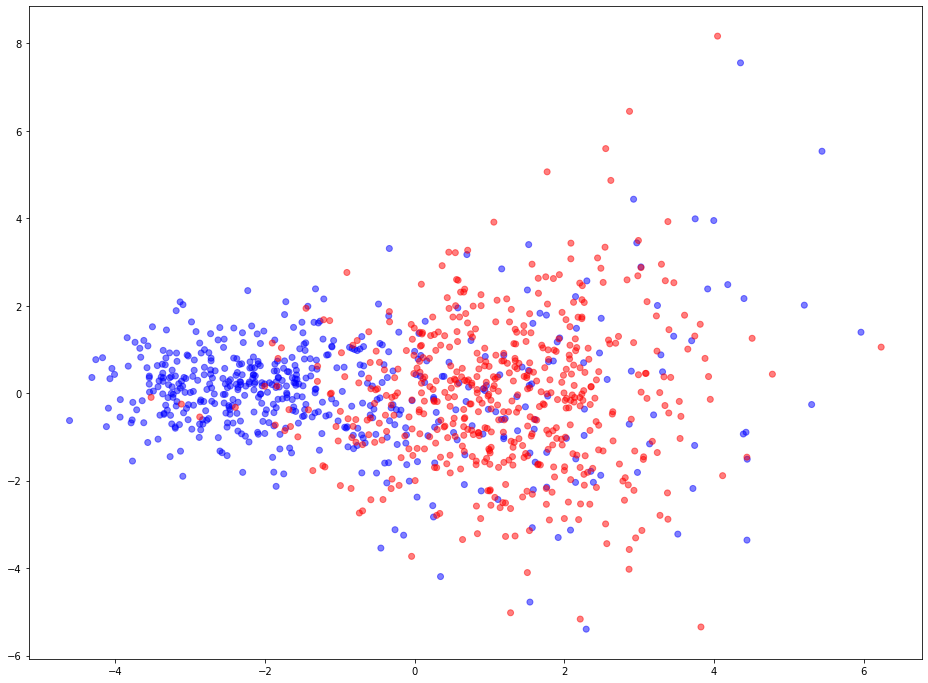

In [14]:
node2vec_result = train_and_evaluate(node2vec_embedding, "Node2Vec")

Training Attri2Vec for 'Train Graph':
link_classification: using 'ip' method to combine node embeddings into edge embeddings
Epoch 1/6
1544/1544 - 6s - loss: 0.7000 - binary_accuracy: 0.5327 - 6s/epoch - 4ms/step
Epoch 2/6
1544/1544 - 6s - loss: 0.6446 - binary_accuracy: 0.6228 - 6s/epoch - 4ms/step
Epoch 3/6
1544/1544 - 6s - loss: 0.5025 - binary_accuracy: 0.7753 - 6s/epoch - 4ms/step
Epoch 4/6
1544/1544 - 6s - loss: 0.3887 - binary_accuracy: 0.8476 - 6s/epoch - 4ms/step
Epoch 5/6
1544/1544 - 6s - loss: 0.3255 - binary_accuracy: 0.8761 - 6s/epoch - 4ms/step
Epoch 6/6
1544/1544 - 6s - loss: 0.2899 - binary_accuracy: 0.8902 - 6s/epoch - 4ms/step

Best result with 'Attri2Vec' embeddings from 'operator_l1'


,ROC AUC
name,
operator_hadamard,0.875705
operator_l1,0.919725
operator_l2,0.915183
operator_avg,0.527796


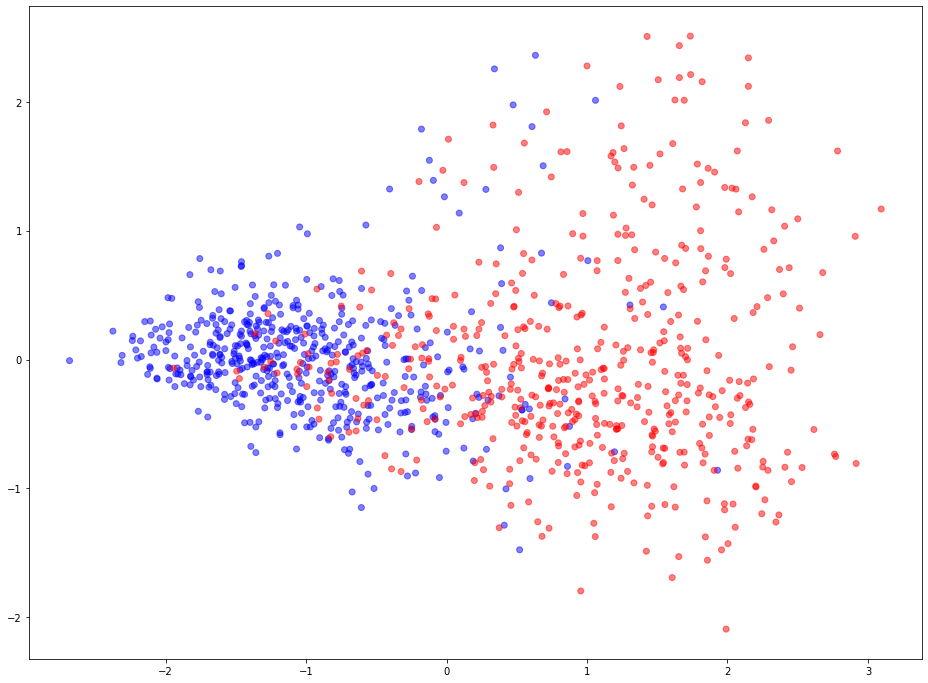

In [18]:
attri2vec_result = train_and_evaluate(attri2vec_embedding, "Attri2Vec")

Training GraphSAGE for 'Train Graph':
link_classification: using 'ip' method to combine node embeddings into edge embeddings
Epoch 1/6
386/386 - 24s - loss: 0.5605 - binary_accuracy: 0.7494 - 24s/epoch - 63ms/step
Epoch 2/6
386/386 - 24s - loss: 0.5370 - binary_accuracy: 0.7782 - 24s/epoch - 63ms/step
Epoch 3/6
386/386 - 23s - loss: 0.5335 - binary_accuracy: 0.7879 - 23s/epoch - 59ms/step
Epoch 4/6
386/386 - 23s - loss: 0.5347 - binary_accuracy: 0.7858 - 23s/epoch - 59ms/step
Epoch 5/6
386/386 - 23s - loss: 0.5317 - binary_accuracy: 0.7951 - 23s/epoch - 59ms/step
Epoch 6/6
386/386 - 23s - loss: 0.5320 - binary_accuracy: 0.7972 - 23s/epoch - 59ms/step

Best result with 'GraphSAGE' embeddings from 'operator_hadamard'


,ROC AUC
name,
operator_hadamard,0.894822
operator_l1,0.888083
operator_l2,0.887717
operator_avg,0.625284


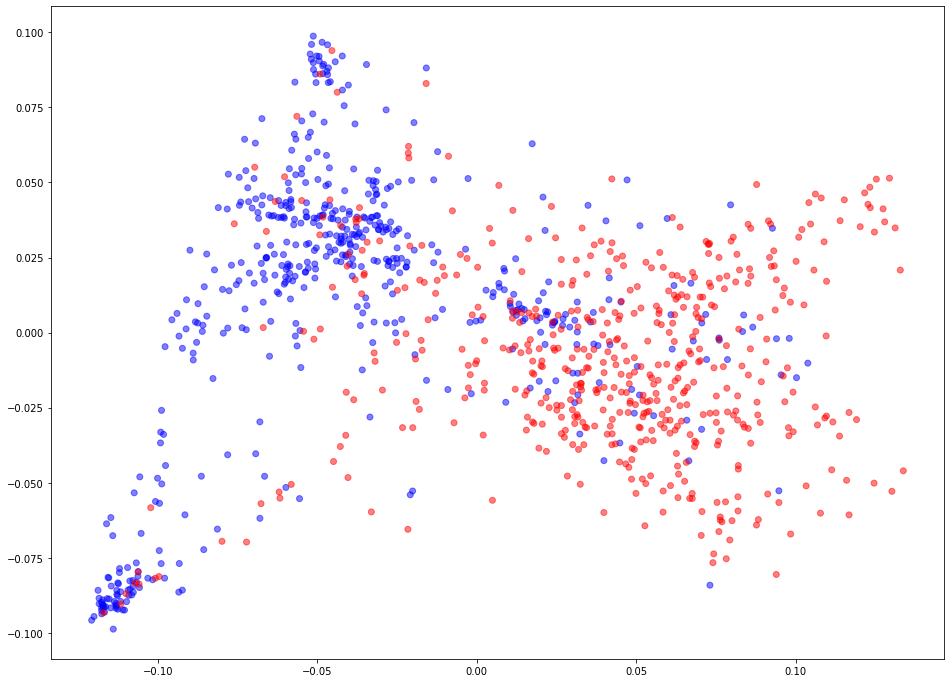

In [19]:
graphsage_result = train_and_evaluate(graphsage_embedding, "GraphSAGE")

Training GCN for 'Train Graph':
Using GCN (local pooling) filters...


C:\Users\milto\anaconda3\envs\kul\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch: 1/6
386/386 - loss: 0.4625 - binary_accuracy: 0.7174
Epoch: 2/6
386/386 - loss: 0.4333 - binary_accuracy: 0.8043
Epoch: 3/6
386/386 - loss: 0.4123 - binary_accuracy: 0.8696
Epoch: 4/6
386/386 - loss: 0.4038 - binary_accuracy: 0.8478
Epoch: 5/6
386/386 - loss: 0.3907 - binary_accuracy: 0.9130
Epoch: 6/6
386/386 - loss: 0.3788 - binary_accuracy: 0.9348
1/1 [==============================] - 0s 179ms/step

Best result with 'GCN' embeddings from 'operator_hadamard'


,ROC AUC
name,
operator_hadamard,0.918406
operator_l1,0.806929
operator_l2,0.760199
operator_avg,0.571157


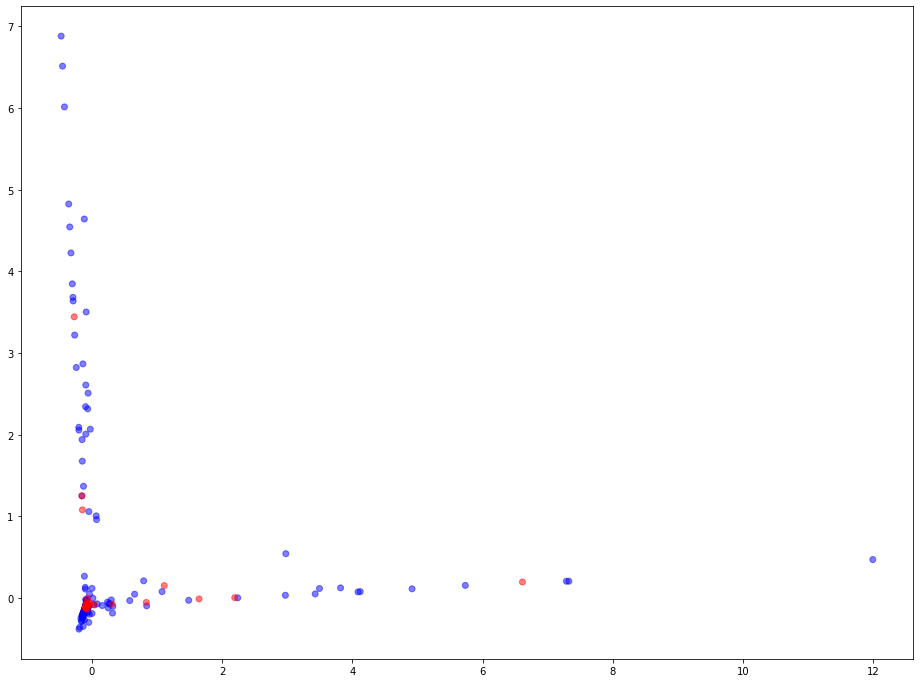

In [20]:
gcn_result = train_and_evaluate(gcn_embedding, "GCN")